In [ ]:
# Bu proje Google Colab üzerinde geliştirilmiştir. Farklı IDE veya ortamlarda çalıştırılırken ek konfigürasyon ya da paket uyumluluğu ayarlamaları gerekebilir.

In [2]:
!pip install osmnx networkx matplotlib folium geopandas
!pip install --upgrade osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.3/101.3 kB 4.2 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/osmnx/_overpass.py:267: UserWarning: This area is 16 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)
/tmp/ipython-input-3-705032615.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


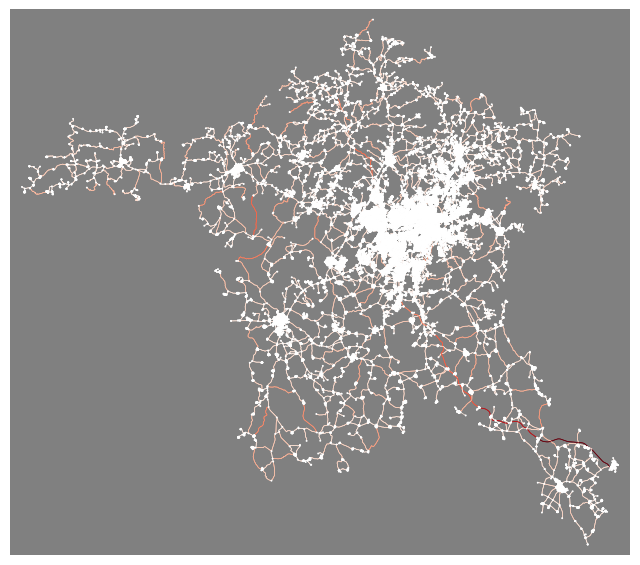

In [3]:
#Trafik analizleri ve güzergah hesaplamalarında kullanabilmek için Ankara’daki tüm sürülebilir yolları içeren bir çizgi-çizelge haritası oluşturuyorum.
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

city = "Ankara, Turkey"
graph_drive = ox.graph_from_place(city, network_type="drive")
edge_lengths = [data["length"] for _, _, data in graph_drive.edges(data=True)] #kenar uzunluklarını listeleme
cmap = cm.get_cmap("Reds")   # Yol uzunluğu arttıkça rengi daha koyu kırmızıya çevrilir.
norm = plt.Normalize(vmin=min(edge_lengths), vmax=max(edge_lengths))
edge_colors = [cmap(norm(data["length"])) for _, _, data in graph_drive.edges(data=True)]

fig, ax = ox.plot_graph(graph_drive, node_size=2, edge_linewidth=0.5, edge_color=edge_colors, bgcolor="gray")



In [ ]:
import osmnx as ox
import folium
import networkx as nx

place_name = "Ankara, Turkey"
graph = ox.graph_from_place(place_name, network_type="all")

nodes, edges = ox.graph_to_gdfs(graph)
center_lat, center_lon = nodes.geometry.y.mean(), nodes.geometry.x.mean() # Haritanın ortalanacağı koordinatı belirler.

# Belirlenen merkezde, 12 lik yakınlaştırmayla ve “cartodbpositron” taban katmanıyla (daha nötr, açık tonlu tasarım) bir harita nesnesi yaratır.
m = folium.Map(location=[center_lat, center_lon], zoom_start=12, tiles="cartodbpositron")

# Yolları haritaya ekle
folium.GeoJson(edges.geometry.__geo_interface__, name="Yol Ağı", style_function=lambda x: {"color": "blue"}).add_to(m)

# Haritayı kaydetme ve indirme (Colab için)
m.save("ankara_yol_agı.html")
print("Harita kaydedildi: ankara_yol_agı.html")

from google.colab import files

files.download("/content/ankara_yol_agı.html")

In [ ]:
import requests
import folium
# Gerçek zamanlı trafik verisi almak için API key'i TomTom'dan alıyoruz.

API_KEY = "API_KEY_Burada"
# URL şablonunda <> içindeki alanları kendi koordinatlarınızla ve API key’inizle dolduracaksınız.
# point=LATITUDE,LONGITUDE - istediğiniz noktanın enlem,boylam değeri

URL = (
    "https://api.tomtom.com/traffic/services/4/"
    "flowSegmentData/absolute/10/json"
    "?point=<LATITUDE>,<LONGITUDE>&unit=KMPH"
    f"&key={API_KEY}"
)
# API’den gerçek zamanlı trafik verisi çeker
response = requests.get(URL)
print(response.content)
data = response.json()

# Trafik yoğunluğu
current_speed = data["flowSegmentData"]["currentSpeed"]
free_flow_speed = data["flowSegmentData"]["freeFlowSpeed"]

# Yoğunluk hesaplama
if current_speed < free_flow_speed * 0.4:
    density = "high"
elif current_speed < free_flow_speed * 0.7:
    density = "medium"
else:
    density = "low"

color = {"high": "red", "medium": "orange", "low": "green"}[density]

# Harita oluştur
m = folium.Map(location=[39.9208, 32.8541], zoom_start=12)
folium.PolyLine([(39.9208, 32.8541), (39.9334, 32.8597)], color=color, weight=6).add_to(m)

# Haritayı kaydetme ve indirme (Colab için)
m.save("ankara_trafik_api.html")
from google.colab import files
files.download("/content/ankara_trafik_api.html")

# Harita oluştur
m = folium.Map(location=[39.9208, 32.8541], zoom_start=12)

#  Bazı önemli otobüs durakları marker’ları
bus_stops = [
    {"name": "Kızılay", "lat": 39.9208, "lon": 32.8541},
    {"name": "Ostim", "lat": 39.9512, "lon": 32.7336},
    {"name": "Ulus", "lat": 39.9334, "lon": 32.8597}
]
for stop in bus_stops:
    folium.Marker(
        [stop["lat"], stop["lon"]],
        popup=stop["name"],
        icon=folium.Icon(color="blue", icon="bus")
    ).add_to(m)

#  En Kısa Yolu Çizer (Sarı Çizgi)
shortest_path = [(39.9208, 32.8541), (39.9334, 32.8597), (39.9512, 32.7336)]
folium.PolyLine(shortest_path, color="yellow", weight=5, opacity=0.8).add_to(m)

#  Trafik Yoğunluğu (Renkli Çizgiler)
traffic_data = [
    {"start": [39.9208, 32.8541], "end": [39.9334, 32.8597], "density": "high"},
    {"start": [39.8936, 32.8766], "end": [39.8845, 32.8557], "density": "medium"},
    {"start": [39.9512, 32.7336], "end": [39.9746, 32.7467], "density": "low"}
]
colors = {"high": "red", "medium": "orange", "low": "green"}
for road in traffic_data:
    folium.PolyLine(
        [road["start"], road["end"]],
        color=colors[road["density"]],
        weight=6,
        opacity=0.7
    ).add_to(m)

m.save("ankara_birlesik_harita.html")
print("Harita başarıyla oluşturuldu!")


from google.colab import files

files.download("/content/ankara_birlesik_harita.html")
